In [ ]:
!git clone https://github.com/sfdnas-adm/market-sentiment-stock-predictor.git
%cd market-sentiment-stock-predictor


Cloning into 'market-sentiment-stock-predictor'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 13 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (13/13), 4.31 KiB | 4.31 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/market-sentiment-stock-predictor


In [ ]:
!pip install transformers datasets torch accelerate gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import pandas as pd

# Replace with your actual file path
file_path = '/content/drive/MyDrive/prompt/stock_/stock_data.csv'
df = pd.read_csv(file_path)

# Display the first few rows
df.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country,Capital Gains
0,2025-02-21 00:00:00-05:00,9.090000,9.100000,8.445000,8.560000,16887800.0,0.0,0.0,peloton,PTON,fitness,usa,NaN
1,2025-02-21 00:00:00-05:00,180.169998,180.169998,176.940002,177.110001,638900.0,0.0,0.0,toyota,TM,automotive,japan,NaN
2,2025-02-21 00:00:00-05:00,128.570007,129.119995,126.940002,127.589996,40500.0,0.0,0.0,adidas,ADDYY,apparel,germany,NaN
3,2025-02-21 00:00:00-05:00,304.940002,304.940002,293.850006,295.399994,3278300.0,0.0,0.0,american express,AXP,finance,usa,NaN
4,2025-02-21 00:00:00-05:00,30.507999,30.510000,29.605000,29.605000,200.0,0.0,0.0,puma,PMMAF,apparel,germany,NaN


In [ ]:
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
                'Stock Splits', 'Capital Gains']

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
# If you want to remove timezone (make it 'tz-naive'):
df['Date'] = df['Date'].dt.tz_localize(None)


In [ ]:
string_cols = ['Brand_Name', 'Ticker', 'Industry_Tag', 'Country']
df[string_cols] = df[string_cols].astype(str)


In [ ]:
print(df.shape)


(303815, 13)


In [ ]:

print("Number of unique tickers:", df['Ticker'].nunique())
print("Number of unique brands:", df['Brand_Name'].nunique())
print("Number of unique industries:", df['Industry_Tag'].nunique())
print("Number of unique countries:", df['Country'].nunique())


Number of unique tickers: 61
Number of unique brands: 61
Number of unique industries: 23
Number of unique countries: 7


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

###############################################################################
# 1. SETUP
###############################################################################

# Assumes you have a DataFrame called df with columns:
# ['Date', 'Brand_Name', 'Open', 'High', 'Low', 'Close', 'Volume', ...]
# Make sure df is sorted by ['Brand_Name', 'Date'] already.

feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
target_col = 'Close'
seq_length = 20
batch_size = 32
num_epochs = 200
learning_rate = 1e-4


In [ ]:

###############################################################################
# 2. UTILITY FUNCTIONS
###############################################################################

def create_sequences(features, target, seq_length):
    """
    Creates sliding windows of length `seq_length` from the given arrays.
    features: scaled feature array (num_samples, num_features)
    target: scaled target array (num_samples, 1)
    seq_length: length of the sequence window

    Returns:
    X_seq: shape (num_sequences, seq_length, num_features)
    y_seq: shape (num_sequences,)
    """
    X_seq, y_seq = [], []
    for i in range(len(features) - seq_length):
        X_seq.append(features[i : i+seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

class TimeSeriesDataset(Dataset):
    """
    PyTorch Dataset for time series data.
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.y[idx], dtype=torch.float32)
        )

class StockLSTM(nn.Module):
    """
    Simple LSTM model for regression.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size=1, dropout=0.2):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        # Take the output of the last time step
        out = self.fc(out[:, -1, :])  # shape: (batch_size, 1)
        return out


In [ ]:
def train_single_brand(sub_df, brand_name):
    """
    Trains an LSTM model for the given brand_name using sub_df data.
    Returns: (model, test_loss, preds_inv, actuals_inv) for the brand
    """
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader

    # Sort by date just to be sure
    sub_df.sort_values(by='Date', inplace=True)
    sub_df.reset_index(drop=True, inplace=True)

    # 1. Train-test split (time-based, e.g., 80/20)
    split_index = int(0.8 * len(sub_df))
    train_df = sub_df.iloc[:split_index].copy()
    test_df = sub_df.iloc[split_index:].copy()

    # 2. Scale features and target
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    train_features = train_df[feature_cols].values
    train_target = train_df[[target_col]].values  # shape (n,1)
    scaler_x.fit(train_features)
    scaler_y.fit(train_target)

    X_train_scaled = scaler_x.transform(train_features)
    y_train_scaled = scaler_y.transform(train_target)

    test_features = test_df[feature_cols].values
    test_target = test_df[[target_col]].values
    X_test_scaled = scaler_x.transform(test_features)
    y_test_scaled = scaler_y.transform(test_target)

    # 3. Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)

    if len(X_train_seq) == 0 or len(X_test_seq) == 0:
        print(f"[{brand_name}] Not enough data after seq creation. Skipping.")
        return None, None, None, None

    # 4. Create DataLoaders
    train_dataset = TimeSeriesDataset(X_train_seq, y_train_seq)
    test_dataset = TimeSeriesDataset(X_test_seq, y_test_seq)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 5. Define and train the model
    input_size = len(feature_cols)
    hidden_size = 128
    num_layers = 3
    model = StockLSTM(input_size, hidden_size, num_layers, dropout=0.2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)           # shape: [batch_size, 1]
            outputs = outputs.view(-1)         # make it [batch_size]
            y_batch = y_batch.view(-1)         # make it [batch_size]

            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        # Optional debug print:
        # if (epoch+1) % 5 == 0:
        #     print(f"[{brand_name}] Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # 6. Evaluate on test set
    model.eval()
    test_loss = 0.0
    preds_list, actuals_list = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)          # shape: [batch_size, 1]
            outputs = outputs.view(-1)        # make it [batch_size]
            y_batch = y_batch.view(-1)        # make it [batch_size]

            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)

            # Collect predictions and actuals
            preds_list.extend(outputs.tolist())
            actuals_list.extend(y_batch.tolist())

    test_loss /= len(test_loader.dataset)

    # 7. Inverse transform predictions and actuals
    preds_arr = np.array(preds_list).reshape(-1,1)
    actuals_arr = np.array(actuals_list).reshape(-1,1)

    preds_inv = scaler_y.inverse_transform(preds_arr).flatten()
    actuals_inv = scaler_y.inverse_transform(actuals_arr).flatten()

    return model, test_loss, preds_inv, actuals_inv


In [ ]:


###############################################################################
# 4. MAIN LOOP: TRAIN A SEPARATE MODEL FOR EACH BRAND
###############################################################################

unique_brands = df['Brand_Name'].unique()

results = {}

for brand in unique_brands:
    sub_df = df[df['Brand_Name'] == brand].copy()
    if len(sub_df) < 50:  # or any minimum threshold
        print(f"[{brand}] Not enough data rows. Skipping.")
        continue

    model, test_loss, preds_inv, actuals_inv = train_single_brand(sub_df, brand)

    if model is None:
        # This means we couldn't form sequences, skip
        continue

    # Store or print results
    results[brand] = {
        'model': model,
        'test_loss': test_loss,
        'predictions': preds_inv,
        'actuals': actuals_inv
    }
    print(f"[{brand}] Test MSE: {test_loss:.4f}, #Predictions: {len(preds_inv)}")


[peloton] Test MSE: 0.0000, #Predictions: 260
[toyota] Test MSE: 0.0159, #Predictions: 1253
[adidas] Test MSE: 0.0002, #Predictions: 931
[american express] Test MSE: 0.1019, #Predictions: 1253
[puma] Test MSE: 0.0003, #Predictions: 616
[visa] Test MSE: 0.0021, #Predictions: 841
[adobe] Test MSE: 0.0338, #Predictions: 1253
[block] Test MSE: 0.0001, #Predictions: 452
[unilever] Test MSE: 0.0003, #Predictions: 1253
[cisco] Test MSE: 0.0005, #Predictions: 1253
[jpmorgan chase & co] Test MSE: 0.0818, #Predictions: 1253
[lvmh] Test MSE: 0.0018, #Predictions: 948
[airbnb] Test MSE: 0.0006, #Predictions: 199
[marriott] Test MSE: 0.0789, #Predictions: 1253
[zoominfo] Test MSE: 0.0002, #Predictions: 226
[hilton] Test MSE: 0.0132, #Predictions: 551
[amd] Test MSE: 0.4780, #Predictions: 1253
[mcdonald's] Test MSE: 0.0338, #Predictions: 1253
[the home depot] Test MSE: 0.0943, #Predictions: 1253
[mastercard] Test MSE: 0.0022, #Predictions: 932
[johnson & johnson] Test MSE: 0.0049, #Predictions: 1253

In [ ]:
# Create a list of (brand, test_mse) tuples
mse_list = [(brand, info['test_loss']) for brand, info in results.items()]

# Sort by test MSE ascending (best = smallest MSE)
mse_list.sort(key=lambda x: x[1])

print("=== Best 5 Brands ===")
for brand, mse_val in mse_list[:5]:
    print(f"{brand} -> MSE: {mse_val:.4f}")

print("\n=== Worst 5 Brands ===")
for brand, mse_val in mse_list[-5:]:
    print(f"{brand} -> MSE: {mse_val:.4f}")


=== Best 5 Brands ===
peloton -> MSE: 0.0000
zoom video communications -> MSE: 0.0000
ubisoft -> MSE: 0.0001
block -> MSE: 0.0001
porsche -> MSE: 0.0002

=== Worst 5 Brands ===
microsoft -> MSE: 0.3050
amd -> MSE: 0.4780
apple -> MSE: 0.5788
costco -> MSE: 1.2223
nvidia -> MSE: 1.9221


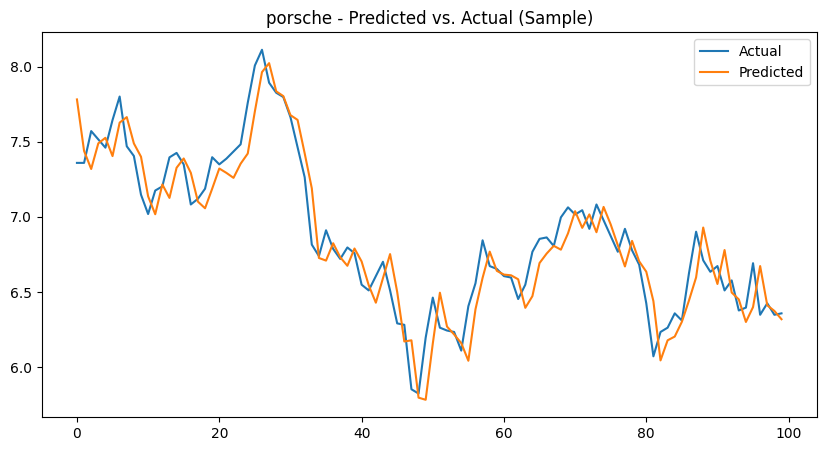

In [ ]:
import matplotlib.pyplot as plt

some_brand = "porsche"  # Example brand name here

if some_brand in results:
    preds = results[some_brand]['predictions']
    actuals = results[some_brand]['actuals']

    # Pick how many data points to show
    sample_size = min(len(preds), 100)

    plt.figure(figsize=(10, 5))
    plt.plot(range(sample_size), actuals[:sample_size], label='Actual')
    plt.plot(range(sample_size), preds[:sample_size], label='Predicted')
    plt.title(f"{some_brand} - Predicted vs. Actual (Sample)")
    plt.legend()
    plt.show()
else:
    print(f"{some_brand} not found in results.")


In [ ]:
some_brand = "apple"  # Replace with a real brand in your data
if some_brand in results:
    preds = results[some_brand]['predictions']
    actuals = results[some_brand]['actuals']

    sample_size = min(len(preds), 10)  # Show first 10 for brevity
    for i in range(sample_size):
        print(f"Index {i}: Actual = {actuals[i]:.2f}, Predicted = {preds[i]:.2f}")
else:
    print(f"{some_brand} not found in results.")


Index 0: Actual = 68.10, Predicted = 69.24
Index 1: Actual = 70.34, Predicted = 69.71
Index 2: Actual = 71.82, Predicted = 70.24
Index 3: Actual = 70.67, Predicted = 71.03
Index 4: Actual = 71.67, Predicted = 71.39
Index 5: Actual = 72.74, Predicted = 71.52
Index 6: Actual = 73.49, Predicted = 72.10
Index 7: Actual = 74.25, Predicted = 73.00
Index 8: Actual = 76.02, Predicted = 73.92
Index 9: Actual = 77.22, Predicted = 74.91


In [ ]:
torch.save(model.state_dict(), f"{brand}_model.pth")


In [ ]:
# inference.py

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [ ]:

###############################################################################
# 1. Model Definition (Match Training)
###############################################################################
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1, dropout=0.2):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # last time step
        return out


In [ ]:

###############################################################################
# 2. Load Model Function
###############################################################################
def load_model(model_path, input_size=5, hidden_size=128, num_layers=3, dropout=0.2):
    """
    Loads the state dict from a .pth file and returns a StockLSTM model in eval mode.
    The hyperparameters (input_size, hidden_size, num_layers, dropout) must match
    how the model was originally trained.
    """
    model = StockLSTM(input_size, hidden_size, num_layers, output_size=1, dropout=dropout)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model


In [ ]:

###############################################################################
# 3. Simple Inference on New Data
###############################################################################
def predict_close_price(model, new_data_df, feature_cols, seq_length=20):
    """
    model: the loaded LSTM model
    new_data_df: a DataFrame with the last 'seq_length' rows for features
    feature_cols: list of columns (e.g. ['Open','High','Low','Close','Volume'])
    seq_length: must match how you formed sequences in training

    Returns: predicted close (float)
    """
    if len(new_data_df) < seq_length:
        raise ValueError(f"Need at least {seq_length} rows to form a sequence.")

    # 1) Scale the new data (simplified approach)
    scaler = MinMaxScaler()
    X = new_data_df[feature_cols].values
    X_scaled = scaler.fit_transform(X)  # in production, you'd use the original scaler

    # 2) Extract the last seq_length rows
    X_input = X_scaled[-seq_length:]
    X_input = np.expand_dims(X_input, axis=0)  # shape: (1, seq_length, num_features)
    X_tensor = torch.tensor(X_input, dtype=torch.float32)

    # 3) Run the model
    with torch.no_grad():
        pred_scaled = model(X_tensor).item()  # single float (scaled)

    # 4) Quick "inverse transform" hack (not perfect but illustrative)
    # We'll place pred_scaled in the 'Close' column index (assume it's the 4th col if feature_cols = 5)
    dummy_array = np.zeros((1, len(feature_cols)))
    dummy_array[0, -1] = pred_scaled  # assume 'Close' is last
    # re-fit scaler on X (unscaled) to get original range
    scaler.fit(X)
    pred_array = scaler.inverse_transform(dummy_array)
    predicted_close = pred_array[0, -1]
    return predicted_close


In [ ]:

###############################################################################
# 4. Example Usage
###############################################################################
if __name__ == "__main__":

    model_path = "/content/nvidia_model.pth"
    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']  # same as training
    seq_length = 20  # same as training

    # Load the model
    model = load_model(
        model_path,
        input_size=len(feature_cols),
        hidden_size=128,   # must match your training
        num_layers=3,      # must match your training
        dropout=0.2
    )

    # Create example data for the last 20 rows (dummy values)
    # In real usage,  gather actual recent data
    data = {
        'Open':   [9.1, 9.2, 9.3, 9.7, 8.9, 8, 11, 27, 18, 17, 16, 15, 16, 12, 9, 9, 9, 8, 9, 10 ],   # 20 values
        'High':   [9.3, 9.4, 9.6, 9.1, 9.2, 9.3, 9.7, 8.9, 8, 11, 27, 18, 17, 16, 15, 16, 12, 9, 9, 10],
        'Low':    [8.9, 9.0, 9.1, 9.2, 9.3, 9.7, 8.9, 8, 11, 27, 18, 17, 16, 15, 16, 12, 9, 9, 9, 8],
        'Close':  [9.2, 9.1, 9.3, 9.0, 9.1, 9.2, 9.3, 9.7, 8.9, 8, 11, 27, 18, 17, 16, 15, 16, 12, 9, 10 ],
        'Volume': [1000, 980, 995, 998, 998, 992, 1000, 990, 998, 1002, 1004, 1102, 1004, 1005, 1006, 1000, 990, 999, 999, 990]
    }
    new_data_df = pd.DataFrame(data)

    # Predict
    pred_close = predict_close_price(model, new_data_df, feature_cols, seq_length)
    print(f"Predicted Next Close: {pred_close:.2f}")


Predicted Next Close: 990.06


<ipython-input-37-cdf87d343467>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
